# [1] Check the accuracy of $\overline{W}(x)$ in a $M/M/1/PS$

Here $W(x)=\mathbb{P}(W>x)$, with $W$ being the soujourn time.

Here $\overline{W}(x) = 1 - W(x) = \mathbb{P}(W\le x)$

In [2]:
import os
import sys
from matplotlib import pyplot as plt
import numpy as np
import ciw


sys.path.append(os.path.join(sys.path[0], '../sojourn_times'))
import sojourn

In [8]:
# Check how W(x=1) varies as we increase infty

Ws = []
infs = list(range(20))
for inf in infs:
    mm1ps = sojourn.MM1PS(mu=4, lambda_=3, infty=inf)
    Ws += [mm1ps.W(1)]

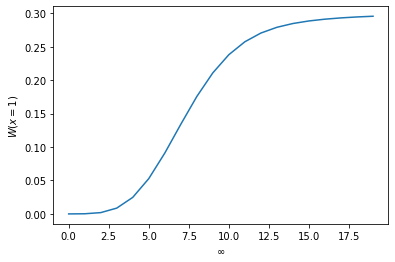

In [9]:
plt.plot(infs, Ws)
plt.xlabel(r'$\infty$')
plt.ylabel(r'$W(x=1)$');

### References

[1] Masuyama, Hiroyuki, and Tetsuya Takine. "Sojourn time distribution in a
    MAP/M/1 processor-sharing queue." Operations Research Letters 31.5 (2003):
    406-412.


## Check if $\overline{W}(x)$ maches CIW values in a PS system

In [10]:
import ciw

lamb, mu = 3, 4

N = ciw.create_network(
    arrival_distributions=[ciw.dists.Exponential(lamb)],
    service_distributions=[ciw.dists.Exponential(mu)],
    number_of_servers=[float('inf')]
)
Q = ciw.Simulation(N, node_class=ciw.PSNode)
Q.simulate_until_max_time(1000)
recs = Q.get_all_records()

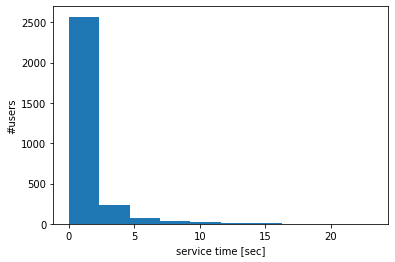

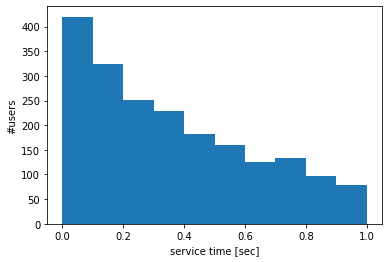

In [11]:
# Get an idea on how service times look
plt.hist([r.service_time for r in recs]);
plt.xlabel('service time [sec]')
plt.ylabel('#users');
plt.show();
#
plt.hist([r.service_time for r in recs if r.service_time < 1]);
plt.xlabel('service time [sec]')
plt.ylabel('#users');

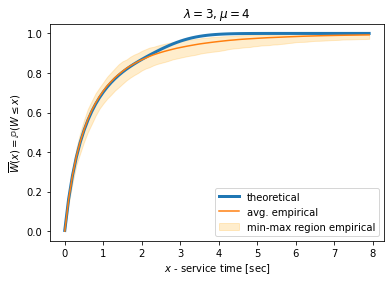

In [12]:
import numpy as np

gran = .1 # time granularity
xs = [x*gran for x in range(int(8*1/gran))]

# Run 40 simulations to derive avg. W_(x)
W_s_emp = []
sims = 40
for _ in range(sims):    
    Q = ciw.Simulation(N, node_class=ciw.PSNode)
    Q.simulate_until_max_time(1000)
    recs = Q.get_all_records()
    W_xs_emp = [len([r for r in recs if r.service_time <= x]) / len(recs)\
                for x in xs]
    W_s_emp.append( W_xs_emp )
W_s_emp = np.array(W_s_emp)

# Derive avg, (min,max) values for service time W
avg_W_s_emp = np.mean(W_s_emp, axis=0)
min_W_s_emp = np.amin(W_s_emp, axis=0)
max_W_s_emp = np.amax(W_s_emp, axis=0)
    


# Derive theoretical values for W_(x)
mm1ps = sojourn.MM1PS(mu=mu, lambda_=lamb, infty=20)
W_xs = [1 - mm1ps.W(x) for x in xs]


plt.plot(xs, W_xs, label='theoretical', lw=3)
plt.plot(xs, avg_W_s_emp, label='avg. empirical')
plt.fill_between(xs, min_W_s_emp, max_W_s_emp, alpha=0.2,label='min-max region empirical', color='orange')
plt.legend();
plt.xlabel(r'$x$ - service time [sec]')
plt.ylabel(r'$\overline{W}(x)=\mathbb{P}(W \leq x)$');
plt.title(r'$\lambda={}, \mu={}$'.format(lamb, mu));

# plt.xlim([0,1]) <- if you zoom in, this refion looks

# $W(x)$ on a $M_n/M/1/PS$ system

In [2] authors state that a single server of a $M/M/R/JSQ/PS$ system behaves as a
$M_n/M/1/PS$.

Here $M_n$ denotes a Poisson arrival process with state dependant rate.
In particular, such a process has arrival rate $\lambda(n)$ with $n$ being
the number of users in the server of interest.

The higher the $n$, the lower the arrival rate. As the JSQ policy
will not dispatch arrivals there.

[2] states that simulation yields
$$ \frac{\lambda(n)}{\mu} \sim \rho^k,\quad n\ge3 $$

-----

An $M_n$ arrival process is a Markovian process, hence,
we use [1] to derive $\overline{W}(x)$ in a $M_n/M/1/PS$ process.

## Birth-death process

We will mimic how an $M/M/1/PS$ is in [2], to derive the
reasoning for our $M_n/M/1/PS$ system.

### $M/M/1$
According to [3], an $M/M/1$ is a birth-death process.
Following the notation of [Section 2 - 3rd paragraph, 2], we have:

$$C = -\lambda I $$
$$ D = \left(\begin{matrix}
    0 & \lambda & 0 & 0 & \ldots \\
    \mu & -\mu & \lambda & 0 & \ldots\\
    0 & \mu & -\mu & \lambda & \ldots\\
    \ldots & \ldots & \ldots & \ldots & \ldots\\
\end{matrix}\right)
$$

Hence, it satisfies ${\bf \pi}(C+D)=0$. With
$$ {\bf \pi} = (\pi_0, \ldots, \pi_n) $$
being the probability of being in state $0,\ldots,n$.
That is, the probability of having $0,\ldots,n$ users in the system.

The generation matrix is $Q=C+D$.

### $M/M/1/PS$
The generation matrix of the associated birth death process is the same.
This is because the CTMC (continious time markov chain) matches.
See [Section 22.3, 4]

### $M_n/M/1/PS$
The only difference with respect to the previous systems,
is that the arrival rate depends on the number of users.
Hence, one gets:

$$C=\left(\begin{matrix}
    -\lambda(0) & 0 & 0 & \ldots\\
    0 & -\lambda(1) & 0 & \ldots\\
    0 & 0 & -\lambda(2) & \ldots\\
    \ldots & \ldots & \ldots & \ldots\\
\end{matrix}\right)
$$

$$D = \left(\begin{matrix}
    0 & \lambda(0) & 0 & 0 & \ldots \\
    \mu & -\mu & \lambda(1) & 0 & \ldots\\
    0 & \mu & -\mu & \lambda(2) & \ldots\\
    \ldots & \ldots & \ldots & \ldots & \ldots\\
\end{matrix}\right)$$

# Computation of $W(x)$

## $M/M/1/PS$
If we look at [(8),1], we see that the probability of
having $n$ customers in the service is
$$ \lambda^{-1}{\bf \pi_0 R^nD} $$
for the $M/M/1/PS$ this turns out to be
$$(1-\rho)\rho^n$$
that is, the probability of having $n$ users un the system.

As a result, [Corollary 2, 1] provides a closed formula
for the sojourn time inverse CDF $W(x)=\mathbb{P}(W>x)$, with $W$ being the soujourn time.

----


## $M_n/M/1/PS$
We now proceed and derive the ${\bf \pi_0}$, the probability of having 0 users.

We have this CTMC
```txt
   __  λ(0)__   __  λ(1)__ 
  /          \./          \.
 0            1            2   ....
  \.____μ____/ \.____μ____/
```
hence:
$$
{\bf \pi_0} \lambda(0) = {\bf \pi_1} \mu
$$

$$
{\bf \pi_0} \lambda(0) + {\bf \pi_2} \mu  = {\bf \pi_1} (\lambda(1)+\mu)
$$

$$
{\bf \pi_{n-1}} \lambda(n-1) + {\bf \pi_{n+1}} \mu  = {\bf \pi_n} (\lambda(n)+\mu)
$$

Thus, we have:
$$
{\bf \pi_0}  = 1 - \sum_{n=1}^\infty {\bf \pi_n}
$$

with
$$
{\bf \pi_n } = \frac{\prod_{i=0}^{n-1}\lambda(i)}{\mu^n} {\bf \pi_0}
$$

and
$$
{\bf \pi_0} = \left[ 1 + \sum_{n=1}^\infty \frac{1}{\mu^n} \prod_{i=0}^{n-1}\lambda(i) \right]^{-1}
$$


-----

As a result we can derive ${\bf \pi_n}$ for our $M_n/M/1/PS$ system using the
equations above. And substitute the term $$ \lambda^{-1}{\bf \pi_0 R^nD} $$
of [(8),1] by ${\bf \pi_n}$

-----

The only thing left is to compute $h_{n,k+1}$ as it appears
in [Corollary 2, 1].

Based on [(9),1], and [Corollary 2,1] I think that the expression is:

$$ h_{n,k+1}=\frac{n}{n+1}\frac{\mu}{\lambda'+\mu} h_{n-1,k} + \frac{\lambda(n)}{\lambda'+\mu}h_{n+1,k}$$
with $\lambda'=\max \{\lambda(i)\}_i^\infty$.
<span style="color:red">TODO - check if this is ok, I have the feeling that every arrival rate term should be $n$ dependant, i.e., a $\lambda(n)$ term. Revisit (9) and check if it is the case</span>.

Note that [(7),2] states that $\lambda(n)$ stabilizes for $n\ge3$, so we could consider

$$\lambda'=\frac{\rho^k}{\mu}, \quad \rho=\frac{\lambda}{k\mu}$$
with $k$ being the number of servers in a $M/M/k/JSQ/PS$, and $\lambda$ the total arrival rate in such system.

For $\lambda(0),\lambda(1),\lambda(2)$ we use the values reported in
[(9)(11)(12), 2]

----------


### On a more precise expression for $\overline{W }(x)$

[Theorem 1, 1] states that

$$ {{\bf h_{n,k+1}}} = \frac{1}{\theta+\mu} \left[ \frac{n\mu}{n+1} {{\bf h_{n-1,k}}} + (\theta {{\bf I}} + {{\bf C}}){{\bf h_{n,k}}} + {\bf Dh_{n+1,k}} \right] $$

Since ${{\bf C}}_{i,i} = -\lambda(i)$, and ${\bf D}$ looks as stated above, we have:

$$ (\theta {\bf I} + {\bf C}) {\bf h_{n,k}} = [\lambda' - \lambda(n)]{\bf h_{n,k}} $$

and

$$ {\bf D h_{n+1,k} } = \lambda (n+1) {\bf h_{n+1,k} } $$
with $\lambda(n),\lambda(n+1)$ denoting the SQA arrival rate when there are $n,n+1$ users in the
$M/M/k/JSQ/PS$ system, respectively.

Bas [Collorary 2, 1] with our $M_n/M/1/PS$ system.

---

As a result our expression ends up being:

$$
h_{n,k+1} = \frac{1}{\lambda'+\mu} \left[ \frac{n\mu}{n+1} h_{n-1,k} + (\lambda'-\lambda(n)) h_{n,k} + \lambda(n+1) h_{n+1,k} \right]
$$

and the terms in [Corollary 2, 1] are:

$$\overline{w}_n(x) = \sum_{k=0}^\infty \frac{(\lambda'+\mu)^kx^k}{k!} e^{-(\lambda'+\mu)x}h_{n,k} $$

$$ \overline{W}(x) = \sum_{n=0}^\infty {\bf \pi_n} \sum_{k=0}^\infty \overline{w}_n(x) $$

# Empirical vs theoretical $M/M/k/JSQ/PS$

implement the above to compute $\overline{W}(x)$ in a $M_n/M/1/PS$ system.

Being such system one of the queues of a $M/M/k/JSQ/PS$.

And see if it matches with simulation

In [3]:
# Parameters
lambda_ = 10
mu = 12
R = 3

# Hyperparameters
max_time = 5000
warmup = 200

class RoutingDecision(ciw.Node):
    def next_node(self, ind):
        """
        Finds the next node by looking at the other nodes,
        seeing how busy they are, and routing to the least busy.
        """
        busyness = {n: self.simulation.nodes[n].number_of_individuals for n in range(2, self.simulation.network.number_of_nodes + 1)}
        chosen_n = sorted(busyness.keys(), key=lambda x: busyness[x])[0]
        return self.simulation.nodes[chosen_n]
 

N = ciw.create_network(
    arrival_distributions=[ciw.dists.Exponential(lambda_)] + [ciw.dists.NoArrivals() for _ in range(R)],
    service_distributions=[ciw.dists.Deterministic(0)] + [ciw.dists.Exponential(mu) for _ in range(R)],
    number_of_servers=[float('inf') for _ in range(R + 1)],
    routing=[[0 for row in range(R + 1)] for col in range(R + 1)]
)

ciw.seed(0)



gran = .1 # time granularity
xs = [x*gran for x in range(int(8*1/gran))]


# Run 40 simulations to derive avg. W_(x)
W_s_emp = []
sims = 40
for _ in range(sims):    
    Q = ciw.Simulation(N, node_class=[RoutingDecision] + [ciw.PSNode for _ in range(R)])
    Q.simulate_until_max_time(max_time)
    print(f'simulation={_}', end='\r')
    recs = Q.get_all_records()
    recs = [r for r in recs if r.arrival_date > warmup and r.arrival_date < max_time - warmup and r.node != 1]
    W_xs_emp = [len([r for r in recs if r.service_time <= x and r.node != 1]) /\
                len([r for r in recs if r.node!=1])\
                for x in xs]
    W_s_emp.append( W_xs_emp )
W_s_emp = np.array(W_s_emp)

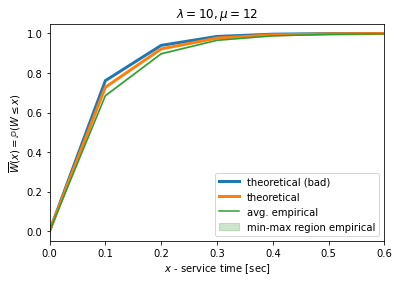

In [6]:
# Derive avg, (min,max) values for service time W
avg_W_s_emp = np.mean(W_s_emp, axis=0)
min_W_s_emp = np.amin(W_s_emp, axis=0)
max_W_s_emp = np.amax(W_s_emp, axis=0)
    


# Derive theoretical values for W_(x)
mmkjsqps = sojourn.MMKJSQPS(mu=mu, lambda_=lambda_, infty=150, K=R)
W_xs_bad = [1 - mmkjsqps.W_bad(x) for x in xs]
W_xs = [1 - mmkjsqps.W(x) for x in xs]



plt.plot(xs, W_xs_bad, label='theoretical (bad)', lw=3)
plt.plot(xs, W_xs, label='theoretical', lw=3)
plt.plot(xs, avg_W_s_emp, label='avg. empirical')
plt.fill_between(xs, min_W_s_emp, max_W_s_emp, alpha=0.2,label='min-max region empirical', color='green')
plt.legend();
plt.xlabel(r'$x$ - service time [sec]')
plt.ylabel(r'$\overline{W}(x)=\mathbb{P}(W \leq x)$');
plt.title(r'$\lambda={}, \mu={}$'.format(lambda_, mu));

plt.xlim([0,.6]); # <- if you zoom in, this refion looks

[2] Gupta, Varun, et al. "Analysis of join-the-shortest-queue routing for web server farms." Performance Evaluation 64.9-12 (2007): 1062-1081.

[3] https://www.cs.cmu.edu/~osogami/thesis/html/node69.html#fig:QBDprocesses

[4] Harchol-Balter, Mor. Performance modeling and design of computer systems: queueing theory in action. Cambridge University Press, 2013.